<a href="https://colab.research.google.com/github/Grantar-alt/evol_methods/blob/main/LR2_GA_variant4_github_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2 — Генетический алгоритм (ЭМППИС)
## Вариант 4: *Moved axis parallel hyper-ellipsoid function*  $f_{1c}(x)$

### Цель работы
Получить практические навыки **реализации генетического алгоритма (ГА)** для поиска глобального минимума тестовой функции и провести **компьютерные эксперименты** по влиянию основных параметров ГА.

### Постановка задания (по методичке ЛР2)
Требуется:

1. **Реализовать** ГА поиска минимума выбранной функции.
2. Для $n=2$ построить графики (контуры/поверхность) и предусмотреть **пошаговый просмотр** процесса поиска решения (эволюции популяции).
3. Повторить поиск решения, используя **стандартный “toolbox”** генетического алгоритма, и **сравнить** результаты.
4. Исследовать зависимость **времени**, **числа поколений** и **точности** от параметров ГА:
   - размер популяции $N$,
   - вероятность кроссинговера $P_c$,
   - вероятность мутации $P_m$.

   Критерий остановки: **повторение лучшего результата** заданное число раз *или* достижение популяцией заданного “возраста” (например, 100 эпох).
5. Повторить поиск решения для $n=3$ и сравнить результаты и скорость.

### Целевая функция варианта 4
В приложении к ЛР2 указана функция:

$$
f_{1c}(x)=\sum_{i=1}^{n} 5\,i\,x_i^2
$$

и отдельно указан оптимум $f(x)=0$ (в таблице также встречается запись $x(i)=5\cdot i$). Для самой формулы $\sum 5\,i\,x_i^2$ **минимум $f(x)=0$ достигается в точке $x=0$**.

> Примечание для защиты: формулировка “moved” обычно означает *сдвиг* оптимума. В литературе часто встречается вариант  
> $\sum 5i\,(x_i-5i)^2$ (тогда оптимум действительно $x_i=5i$).  
> В этом ноутбуке основная реализация следует **буквальной формуле** из таблицы (без сдвига), но ниже добавлен переключатель, позволяющий включить “сдвинутый” вариант для сравнения.

### Область поиска
В методических примерах (кодирование вещественных чисел двоичной строкой) часто используется интервал $[-10;10]$. В данной работе для всех $x_i$ задаём:

$$
x_i \in [-10, 10]
$$

(границы можно менять одним параметром `bounds`).

---

## Как читать этот ноутбук (структура)
1. **Подготовка окружения** и импорт библиотек.
2. **Определение целевой функции**, проверка корректности.
3. **Собственная реализация ГА** (вещественное кодирование): селекция → кроссинговер → мутация → элитизм/редукция → критерий остановки.
4. **Визуализация** ($n=2$): контуры/поверхность + пошаговый просмотр.
5. **“Toolbox”-реализация** на основе библиотеки `DEAP` и сравнение с custom-ГА.
6. **Эксперименты** по параметрам $N, P_c, P_m$ (таблицы и графики зависимостей).
7. Запуск для $n=3$ и сравнение скорости.
8. **Ответы на контрольные вопросы** (для подготовки к защите).


In [1]:
# Установка зависимостей (Google Colab)
!pip -q install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.5 MB/s eta 0:00:00


In [2]:
import time
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
rng_global = np.random.default_rng(SEED)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# ------------------------------------------------------------------------------
# Целевая функция (вариант 4)
# ------------------------------------------------------------------------------
# Основная формула из приложения ЛР2:
#   f1c(x) = sum_{i=1..n} 5*i*x_i^2
#
# В таблице задания также встречается запись "x(i)=5*i" (что типично для "moved"
# функций, т.е. со сдвигом). Чтобы при необходимости показать оба варианта,
# добавим переключатель USE_SHIFT:
USE_SHIFT = False  # True -> использовать сдвиг x_i -> (x_i - 5*i)

def f1c(X: np.ndarray) -> np.ndarray:
    """Целевая функция варианта 4.

    По умолчанию (USE_SHIFT=False):
        f1c(x) = sum_{i=1..n} 5*i*x_i^2

    Если USE_SHIFT=True (пояснение для защиты):
        f1c(x) = sum_{i=1..n} 5*i*(x_i - 5*i)^2

    Поддерживается:
      - X.shape == (n,)         -> scalar
      - X.shape == (pop, n)     -> (pop,)
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[-1]
    w = 5.0 * np.arange(1, n + 1, dtype=float)
    shift = 5.0 * np.arange(1, n + 1, dtype=float) if USE_SHIFT else 0.0
    dx = X - shift
    return np.sum(w * (dx ** 2), axis=-1)

def clip_bounds(X: np.ndarray, low: float, high: float) -> np.ndarray:
    return np.clip(X, low, high)

# Быстрые проверки
print("USE_SHIFT =", USE_SHIFT)
print("f1c([0,0]) =", f1c(np.array([0.0, 0.0])))
print("f1c([1,2]) =", f1c(np.array([1.0, 2.0])))
if USE_SHIFT:
    # В сдвинутом варианте f(5,10)=0 для n=2
    print("f1c([5,10]) =", f1c(np.array([5.0, 10.0])))


USE_SHIFT = False
f1c([0,0]) = 0.0
f1c([1,2]) = 45.0


## 1) Собственная реализация ГА (вещественное кодирование)

### Почему вещественное кодирование
В классическом простом ГА (в методических материалах) вещественное число часто кодируется **двоичной строкой**: выбираются границы $[a;c]$, требуемая точность и длина хромосомы (например, 15 бит для $[-10;10]$ при 3 знаках после запятой). Такой подход удобен для одномерных демонстраций, но для многомерных задач увеличивает длину хромосомы и усложняет операторы.

Для задач с вектором $x\in\mathbb{R}^n$ практичнее использовать **вещественное кодирование**, где особь — это вектор вещественных чисел, а операторы (кроссинговер/мутация) работают напрямую над вещественными генами. Это стандартный подход в эволюционных стратегиях и во многих “real-coded GA”.

### Из каких блоков состоит наш ГА
В соответствии со схемой простого генетического алгоритма:

1. **Инициализация**: случайно генерируем начальную популяцию размера $N$ равномерно в пределах `bounds`.
2. **Оценка (fitness)**: считаем значение целевой функции $f(x)$.  
   Мы решаем задачу **минимизации**, поэтому для рулетки строим “качество” (чем больше — тем лучше), например:

$$
q(x)=\frac{1}{1+f(x)}
$$

3. **Селекция (репродукция)**: выбираем родителей. Здесь используется **рулетка** (пропорционально качеству).
4. **Кроссинговер** с вероятностью $P_c$: для вещественных векторов применяем **арифметический кроссинговер**:

$$
c_1 = \alpha p_1 + (1-\alpha)p_2,\quad
c_2 = (1-\alpha)p_1 + \alpha p_2,\quad \alpha\sim U(0,1)
$$

5. **Мутация** с вероятностью $P_m$: по каждому гену (координате) с вероятностью $P_m$ добавляем гауссов шум:

$$
x' = x + \mathcal{N}(0,\sigma^2)
$$

   После мутации выполняем **ограничение** значений в `bounds`.
6. **Элитизм + редукция**: сохраняем небольшое число лучших особей (элита) и добираем остальное из потомков, чтобы размер популяции оставался $N$.
7. **Критерий останова**:  
   - если лучшее значение **не улучшается** `patience` поколений подряд (это и есть “повторение лучшего результата”),  
   - либо достигнут лимит `max_gens` (возраст популяции).

### Какие метрики мы фиксируем
Для каждого запуска алгоритма печатаем и/или сохраняем:

- `best_x` — лучшая найденная точка;
- `best_f` — значение $f(\text{best\_x})$;
- `n_gen` — число поколений до останова;
- `runtime_s` — время работы;
- `history_best` — кривая сходимости (лучшее значение по поколениям);
- (опционально) `history_pop` — снимки популяции для пошагового просмотра.

Ниже код реализует весь цикл “инициализация → селекция → кроссинговер → мутация → элитизм → останов”.


In [3]:
def roulette_select(quality: np.ndarray, rng: np.random.Generator) -> int:
    """Отбор по рулетке: quality >= 0, чем больше — тем лучше."""
    q = np.asarray(quality, dtype=float)
    s = float(np.sum(q))
    if s <= 0 or not np.isfinite(s):
        # деградация: если качества некорректны — выбираем равновероятно
        return int(rng.integers(0, len(q)))
    r = rng.random() * s
    c = 0.0
    for i, qi in enumerate(q):
        c += float(qi)
        if c >= r:
            return int(i)
    return int(len(q) - 1)

def arithmetic_crossover(p1: np.ndarray,
                         p2: np.ndarray,
                         rng: np.random.Generator,
                         low: float,
                         high: float) -> Tuple[np.ndarray, np.ndarray]:
    """Арифметический (вещественный) кроссовер:
    c1 = a*p1 + (1-a)*p2, c2 = (1-a)*p1 + a*p2, a ~ U(0,1)
    """
    a = rng.random()
    c1 = a * p1 + (1.0 - a) * p2
    c2 = (1.0 - a) * p1 + a * p2
    return clip_bounds(c1, low, high), clip_bounds(c2, low, high)

def gaussian_mutation(x: np.ndarray,
                      rng: np.random.Generator,
                      pm: float,
                      sigma: float,
                      low: float,
                      high: float) -> np.ndarray:
    """Гауссова мутация: каждая координата мутирует с вероятностью pm."""
    x = np.asarray(x, dtype=float).copy()
    mask = rng.random(x.size) < pm
    if np.any(mask):
        x[mask] += rng.normal(0.0, sigma, size=int(np.sum(mask)))
        x = clip_bounds(x, low, high)
    return x

def run_ga_custom(func,
                  n_dim: int,
                  bounds: Tuple[float, float] = (-5.12, 5.12),
                  pop_size: int = 100,
                  pc: float = 0.9,
                  pm: float = 0.1,
                  sigma0: Optional[float] = None,
                  max_gens: int = 200,
                  patience: int = 30,
                  tol: float = 1e-12,
                  keep_history: bool = False,
                  seed: int = 42) -> Dict[str, Any]:
    """Простой ГА для минимизации func.
    Останов: повторение лучшего результата patience раз подряд (с допуском tol)
    или достижение max_gens.
    """
    low, high = bounds
    rng = np.random.default_rng(seed)

    if sigma0 is None:
        sigma0 = 0.1 * (high - low)

    pop = rng.uniform(low, high, size=(pop_size, n_dim))
    fit = func(pop)

    best_idx = int(np.argmin(fit))
    best_x = pop[best_idx].copy()
    best_f = float(fit[best_idx])

    history_best = [best_f]
    history_pop = [pop.copy()] if keep_history else None

    repeats = 0
    t0 = time.perf_counter()

    gen = 0
    for gen in range(1, max_gens + 1):
        # качество для рулетки (чем меньше f — тем выше q)
        quality = 1.0 / (1.0 + fit)

        new_pop = np.empty_like(pop)
        # элитизм
        new_pop[0] = best_x

        i = 1
        while i < pop_size:
            p1 = pop[roulette_select(quality, rng)]
            p2 = pop[roulette_select(quality, rng)]

            c1, c2 = p1.copy(), p2.copy()
            if rng.random() < pc:
                c1, c2 = arithmetic_crossover(p1, p2, rng=rng, low=low, high=high)

            # уменьшение sigma по мере эволюции (стабилизация)
            sigma_gen = max(sigma0 * (1.0 - gen / max_gens), 1e-9)
            c1 = gaussian_mutation(c1, rng=rng, pm=pm, sigma=sigma_gen, low=low, high=high)
            c2 = gaussian_mutation(c2, rng=rng, pm=pm, sigma=sigma_gen, low=low, high=high)

            new_pop[i] = c1
            if i + 1 < pop_size:
                new_pop[i + 1] = c2
            i += 2

        pop = new_pop
        fit = func(pop)

        gen_best_idx = int(np.argmin(fit))
        gen_best_f = float(fit[gen_best_idx])

        if gen_best_f + tol < best_f:
            best_f = gen_best_f
            best_x = pop[gen_best_idx].copy()
            repeats = 0
        else:
            repeats += 1

        history_best.append(best_f)
        if keep_history:
            history_pop.append(pop.copy())

        if repeats >= patience:
            break

    runtime = time.perf_counter() - t0
    return {
        "best_x": best_x,
        "best_f": best_f,
        "n_gen": gen,
        "runtime_s": runtime,
        "history_best": history_best,
        "history_pop": history_pop,
    }


## 2) Базовый запуск для \(n=2\) + графики

Далее:
- запуск ГА;
- график сходимости (лучшее значение по поколениям);
- визуализация функции (контуры и поверхность) и найденной точки минимума.


ГА (custom), n=2
 best_x = [-0.00042785 -0.00038927]
 best_f = 2.4305830965804007e-06
 n_gen  = 81
 time_s = 0.3070552329999998


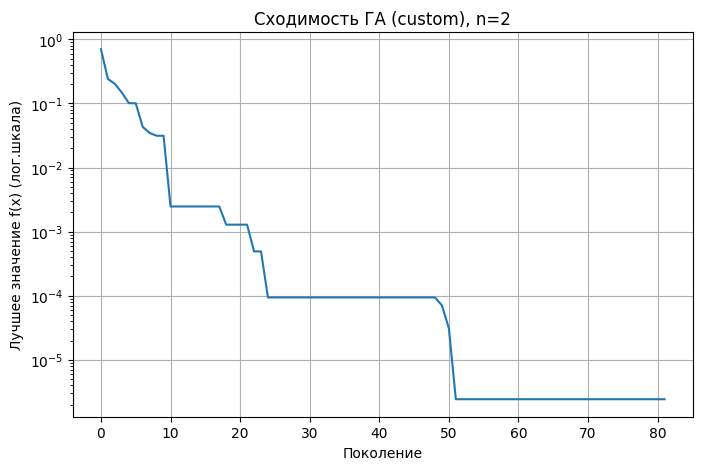

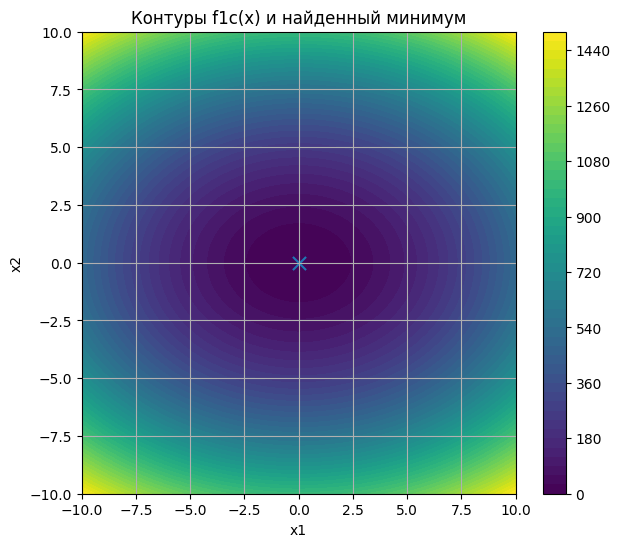

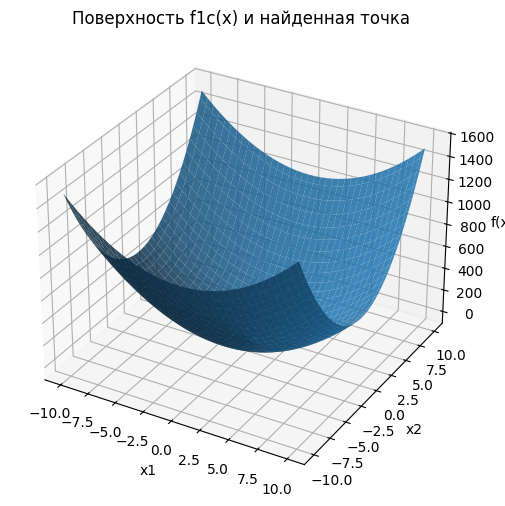

In [4]:
BASE = dict(
    n_dim=2,
    bounds=(-10.0, 10.0),
    pop_size=100,
    pc=0.9,
    pm=0.1,
    sigma0=None,
    max_gens=200,
    patience=30,
    tol=1e-12,
    keep_history=False,
    seed=SEED,
)

res2 = run_ga_custom(f1c, **BASE)

print("ГА (custom), n=2")
print(" best_x =", res2["best_x"])
print(" best_f =", res2["best_f"])
print(" n_gen  =", res2["n_gen"])
print(" time_s =", res2["runtime_s"])

# Сходимость
hist = np.array(res2["history_best"], dtype=float)
plt.figure()
plt.semilogy(np.maximum(hist, 1e-16))
plt.xlabel("Поколение")
plt.ylabel("Лучшее значение f(x) (лог.шкала)")
plt.title("Сходимость ГА (custom), n=2")
plt.show()

# Контуры и поверхность (n=2)
low, high = BASE["bounds"]
grid = np.linspace(low, high, 220)
X1, X2 = np.meshgrid(grid, grid)
Z = f1c(np.stack([X1, X2], axis=-1))

plt.figure(figsize=(7, 6))
cs = plt.contourf(X1, X2, Z, levels=50)
plt.colorbar(cs)
plt.scatter([res2["best_x"][0]], [res2["best_x"][1]], marker="x", s=90)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Контуры f1c(x) и найденный минимум")
plt.show()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X1, X2, Z, rstride=6, cstride=6, linewidth=0, antialiased=True, alpha=0.85)
ax.scatter(res2["best_x"][0], res2["best_x"][1], f1c(res2["best_x"]), marker="x", s=70)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f(x)")
ax.set_title("Поверхность f1c(x) и найденная точка")
plt.show()


## 3) Пошаговый просмотр процесса поиска (для $n=2$)

Сохраняем популяцию по поколениям и отображаем её на фоне контуров функции.
В Google Colab для интерактивного просмотра используется `ipywidgets`.  
Если виджеты недоступны, выводим визуализацию для **последнего поколения**.


In [5]:
# Пошаговый просмотр: сохраняем историю популяций
VIS = BASE.copy()
VIS.update(dict(pop_size=60, max_gens=80, patience=25, keep_history=True, seed=SEED))

res_vis = run_ga_custom(f1c, **VIS)
pops = res_vis["history_pop"]

def plot_generation(gen: int):
    pop_g = pops[gen]
    plt.figure(figsize=(7, 6))
    cs = plt.contourf(X1, X2, Z, levels=50)
    plt.colorbar(cs)
    plt.scatter(pop_g[:, 0], pop_g[:, 1], s=15)
    plt.scatter([res_vis["best_x"][0]], [res_vis["best_x"][1]], marker="x", s=90)
    plt.title(f"Поколение {gen} / {len(pops)-1} (best_f={res_vis['history_best'][gen]:.3e})")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

try:
    import ipywidgets as widgets
    from IPython.display import display
    from google.colab import output
    output.enable_custom_widget_manager()

    slider = widgets.IntSlider(min=0, max=len(pops)-1, step=1, value=0, description="gen")
    out = widgets.Output()

    def on_change(change):
        with out:
            out.clear_output(wait=True)
            plot_generation(change["new"])

    slider.observe(on_change, names="value")
    display(slider, out)

    with out:
        plot_generation(slider.value)

except Exception as e:
    print("ipywidgets недоступны, показываю последнее поколение. Причина:", e)
    plot_generation(len(pops)-1)


IntSlider(value=0, description='gen', max=66)

Output()

## 4) Решение через стандартный *toolbox* (DEAP) и сравнение

В Python практическим аналогом *Genetic Algorithm toolbox* является библиотека **DEAP**.
Ниже:
- настройка `toolbox` (инициализация, evaluate, select, mate, mutate);
- запуск встроенного алгоритма `eaSimple`;
- сравнение с результатом собственной реализации.


DEAP (toolbox), n=2
 best_x = [-1.31896466e-38 -2.07796257e-38]
 best_f = 5.18776231412809e-75
 n_gen  = 200
 time_s = 0.652702019000003


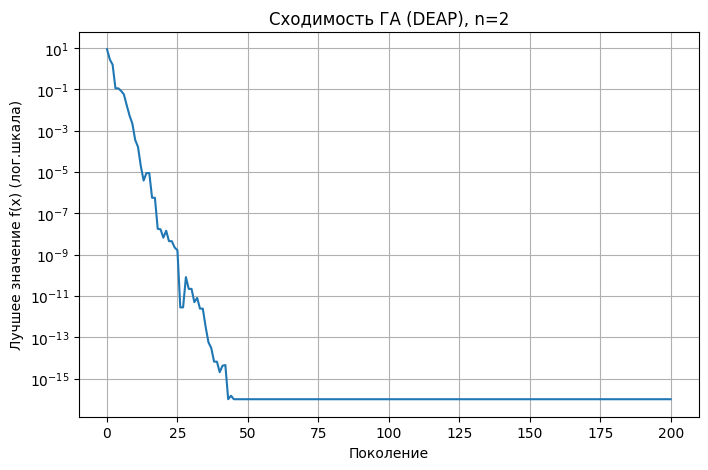


Сравнение best_f (custom vs DEAP): 2.4305830965804007e-06 vs 5.18776231412809e-75


In [6]:
import random
from deap import base, creator, tools, algorithms

def run_deap_toolbox(n_dim: int,
                     bounds: Tuple[float, float],
                     pop_size: int,
                     pc: float,
                     pm: float,
                     max_gens: int,
                     seed: int = 42) -> Dict[str, Any]:
    random.seed(seed)
    low, high = bounds

    # creator нельзя пересоздавать многократно
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, low, high)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_dim)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(ind):
        x = np.array(ind, dtype=float)
        return (float(f1c(x)),)

    toolbox.register("evaluate", evaluate)
    # BLX-alpha (blend) — линейная комбинация родителей
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    # Gaussian mutation по координатам
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=pm)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    t0 = time.perf_counter()
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=pc, mutpb=1.0, ngen=max_gens,
                                  stats=stats, halloffame=hof, verbose=False)
    runtime = time.perf_counter() - t0

    best_ind = hof[0]
    best_x = np.array(best_ind, dtype=float)
    best_f = float(best_ind.fitness.values[0])
    hist_min = [rec["min"] for rec in log]

    return {"best_x": best_x, "best_f": best_f, "n_gen": max_gens, "runtime_s": runtime, "history_best": hist_min}

deap2 = run_deap_toolbox(
    n_dim=2,
    bounds=BASE["bounds"],
    pop_size=BASE["pop_size"],
    pc=BASE["pc"],
    pm=BASE["pm"],
    max_gens=BASE["max_gens"],
    seed=SEED
)

print("DEAP (toolbox), n=2")
print(" best_x =", deap2["best_x"])
print(" best_f =", deap2["best_f"])
print(" n_gen  =", deap2["n_gen"])
print(" time_s =", deap2["runtime_s"])

plt.figure()
plt.semilogy(np.maximum(np.array(deap2["history_best"], dtype=float), 1e-16))
plt.xlabel("Поколение")
plt.ylabel("Лучшее значение f(x) (лог.шкала)")
plt.title("Сходимость ГА (DEAP), n=2")
plt.show()

print("\nСравнение best_f (custom vs DEAP):", res2["best_f"], "vs", deap2["best_f"])


## 5) Эксперименты по параметрам $N,\;P_c,\;P_m$ (таблица + графики)

Для каждого набора параметров выполняем несколько прогонов и считаем:
- среднее/СКО для `best_f` (точность),
- среднее/СКО для числа поколений до останова,
- среднее/СКО для времени.

При необходимости можно увеличить `repeats` для более устойчивой статистики.


,pop_size,best_f_mean,best_f_std,gens_mean,gens_std,time_s_mean,time_s_std
0,20,5.733023e-07,4.976043e-07,129.666667,28.755676,0.159769,0.120838
1,50,8.212884e-06,6.052778e-06,79.000000,9.273618,0.130493,0.015267
2,100,1.382985e-05,1.907918e-05,74.666667,40.185680,0.279399,0.144459
3,200,1.285988e-06,7.357333e-07,70.333333,6.847546,0.602286,0.046652


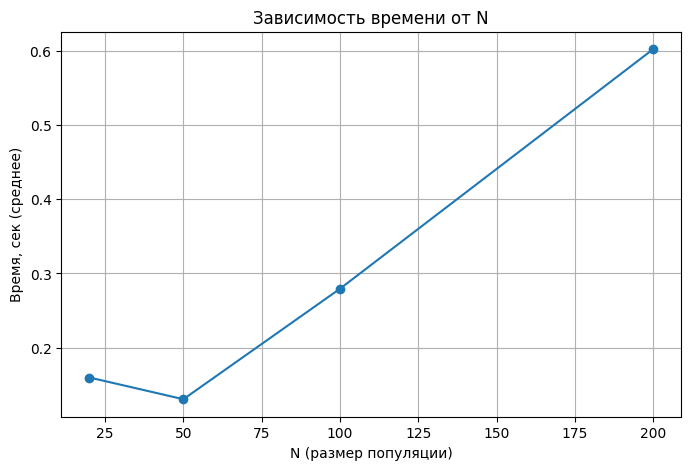

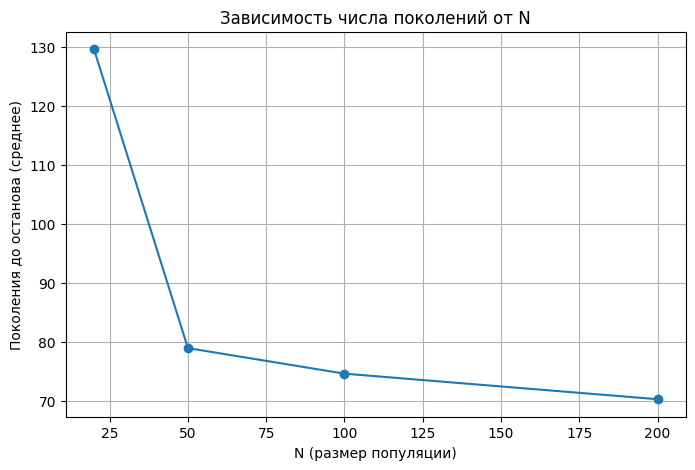

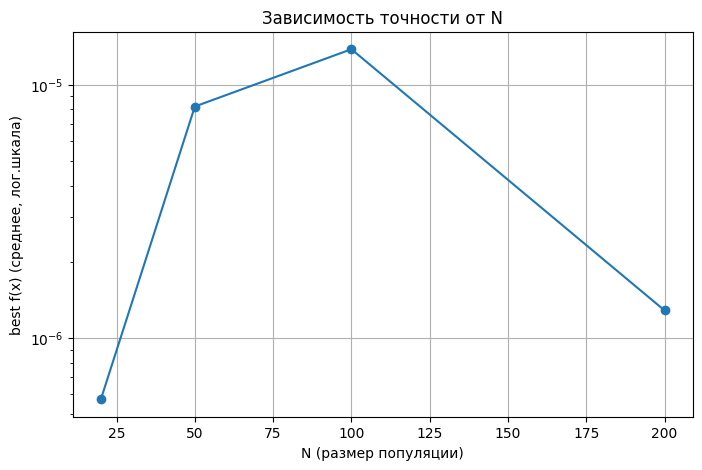

,pc,best_f_mean,best_f_std,gens_mean,gens_std,time_s_mean,time_s_std
0,0.6,0.000017,0.000023,63.666667,24.253293,0.252433,0.084904
1,0.8,0.000084,0.000117,68.333333,18.372685,0.261745,0.079386
2,0.9,0.000014,0.000019,74.666667,40.185680,0.454393,0.317629
3,1.0,0.000026,0.000035,80.666667,30.225082,0.512374,0.218118


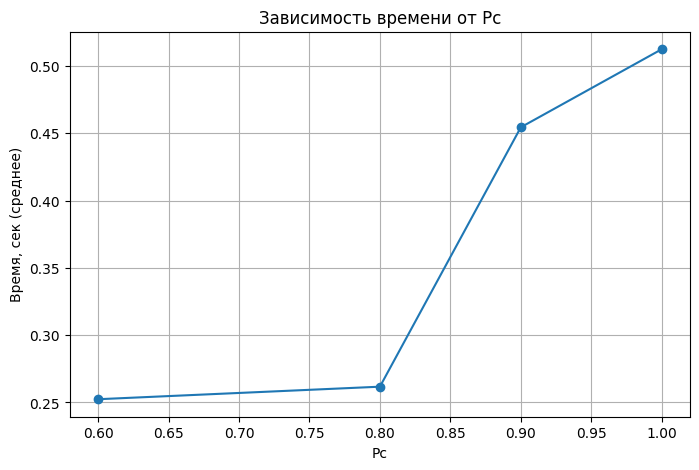

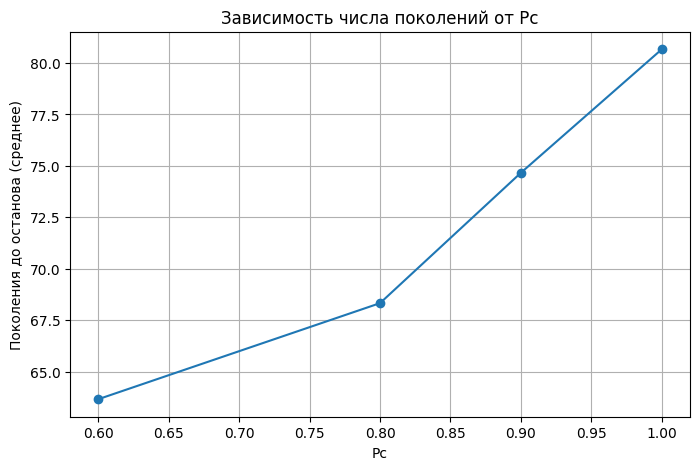

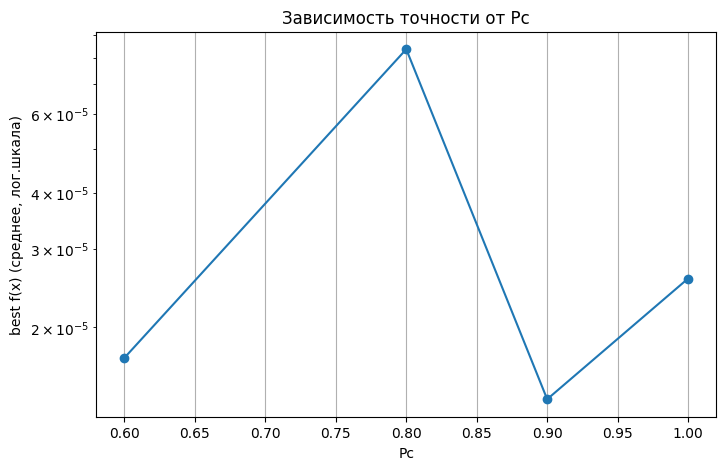

,pm,best_f_mean,best_f_std,gens_mean,gens_std,time_s_mean,time_s_std
0,0.01,0.000070,0.000052,39.333333,5.557777,0.143099,0.010837
1,0.05,0.000001,0.000001,87.000000,10.677078,0.306492,0.036957
2,0.10,0.000014,0.000019,74.666667,40.185680,0.317977,0.137549
3,0.20,0.000002,0.000002,89.666667,17.913372,0.362196,0.056999


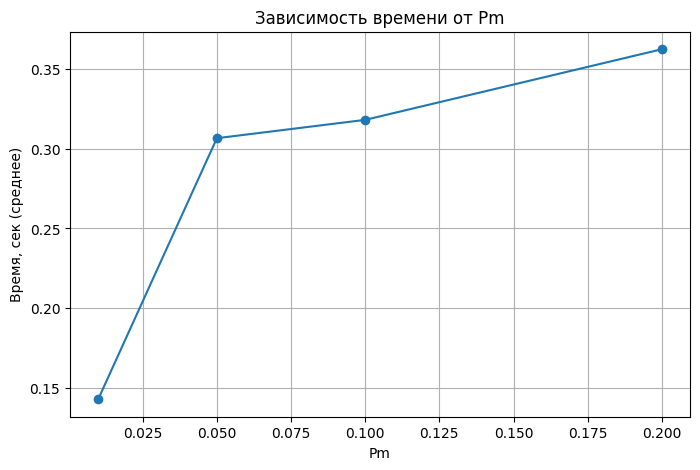

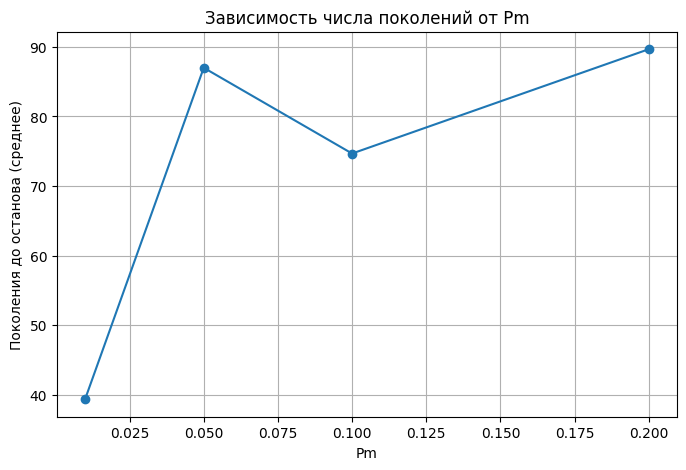

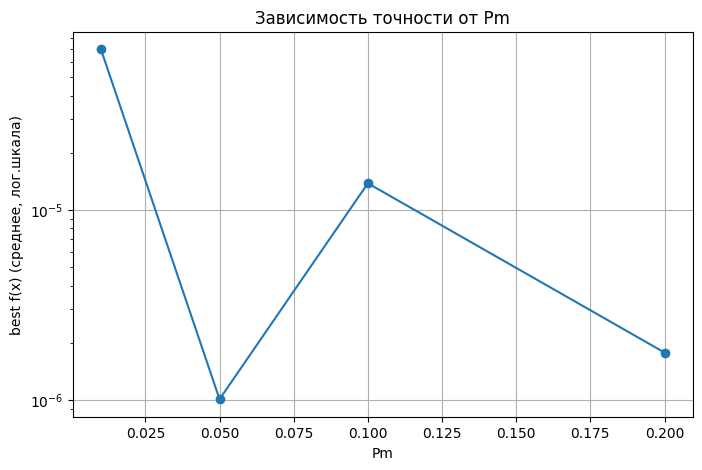

from matplotlib import pyplot as plt
df_Pc['pc'].plot(kind='hist', bins=20, title='pc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc['best_f_mean'].plot(kind='hist', bins=20, title='best_f_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc['best_f_std'].plot(kind='hist', bins=20, title='best_f_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc['gens_mean'].plot(kind='hist', bins=20, title='gens_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc.plot(kind='scatter', x='pc', y='best_f_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc.plot(kind='scatter', x='best_f_mean', y='best_f_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc.plot(kind='scatter', x='best_f_std', y='gens_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_Pc.plot(kind='scatter', x='gens_mean', y='gens_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['pc']
  ys = series['best_f_mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_Pc.sort_values('pc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pc')
_ = plt.ylabel('best_f_mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['pc']
  ys = series['best_f_std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_Pc.sort_values('pc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pc')
_ = plt.ylabel('best_f_std')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['pc']
  ys = series['gens_std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_Pc.sort_values('pc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pc')
_ = plt.ylabel('gens_std')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['pc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'pc'}, axis=1)
              .sort_values('pc', ascending=True))
  xs = counted['pc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_Pc.sort_values('pc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_Pc['pc'].plot(kind='line', figsize=(8, 4), title='pc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_Pc['best_f_mean'].plot(kind='line', figsize=(8, 4), title='best_f_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_Pc['best_f_std'].plot(kind='line', figsize=(8, 4), title='best_f_std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_Pc['gens_mean'].plot(kind='line', figsize=(8, 4), title='gens_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:
def run_experiment_grid(param_name: str,
                        values,
                        base_params: Dict[str, Any],
                        repeats: int = 3,
                        seed0: int = 1000) -> pd.DataFrame:
    rows = []
    for v in values:
        params = dict(base_params)
        params[param_name] = v

        best_f_list = []
        gen_list = []
        time_list = []

        for r in range(repeats):
            params["seed"] = seed0 + r
            out = run_ga_custom(f1c, **params)
            best_f_list.append(out["best_f"])
            gen_list.append(out["n_gen"])
            time_list.append(out["runtime_s"])

        rows.append({
            param_name: v,
            "best_f_mean": float(np.mean(best_f_list)),
            "best_f_std": float(np.std(best_f_list)),
            "gens_mean": float(np.mean(gen_list)),
            "gens_std": float(np.std(gen_list)),
            "time_s_mean": float(np.mean(time_list)),
            "time_s_std": float(np.std(time_list)),
        })

    return pd.DataFrame(rows)

EXP_BASE = BASE.copy()
EXP_BASE.update(dict(keep_history=False, max_gens=200, patience=30))

# 1) N
N_values = [20, 50, 100, 200]
df_N = run_experiment_grid("pop_size", N_values, EXP_BASE, repeats=3)
display(df_N)

plt.figure()
plt.plot(df_N["pop_size"], df_N["time_s_mean"], marker="o")
plt.xlabel("N (размер популяции)")
plt.ylabel("Время, сек (среднее)")
plt.title("Зависимость времени от N")
plt.show()

plt.figure()
plt.plot(df_N["pop_size"], df_N["gens_mean"], marker="o")
plt.xlabel("N (размер популяции)")
plt.ylabel("Поколения до останова (среднее)")
plt.title("Зависимость числа поколений от N")
plt.show()

plt.figure()
plt.semilogy(df_N["pop_size"], np.maximum(df_N["best_f_mean"], 1e-16), marker="o")
plt.xlabel("N (размер популяции)")
plt.ylabel("best f(x) (среднее, лог.шкала)")
plt.title("Зависимость точности от N")
plt.show()

# 2) Pc
Pc_values = [0.6, 0.8, 0.9, 1.0]
df_Pc = run_experiment_grid("pc", Pc_values, EXP_BASE, repeats=3)
display(df_Pc)

plt.figure()
plt.plot(df_Pc["pc"], df_Pc["time_s_mean"], marker="o")
plt.xlabel("Pc")
plt.ylabel("Время, сек (среднее)")
plt.title("Зависимость времени от Pc")
plt.show()

plt.figure()
plt.plot(df_Pc["pc"], df_Pc["gens_mean"], marker="o")
plt.xlabel("Pc")
plt.ylabel("Поколения до останова (среднее)")
plt.title("Зависимость числа поколений от Pc")
plt.show()

plt.figure()
plt.semilogy(df_Pc["pc"], np.maximum(df_Pc["best_f_mean"], 1e-16), marker="o")
plt.xlabel("Pc")
plt.ylabel("best f(x) (среднее, лог.шкала)")
plt.title("Зависимость точности от Pc")
plt.show()

# 3) Pm
Pm_values = [0.01, 0.05, 0.1, 0.2]
df_Pm = run_experiment_grid("pm", Pm_values, EXP_BASE, repeats=3)
display(df_Pm)

plt.figure()
plt.plot(df_Pm["pm"], df_Pm["time_s_mean"], marker="o")
plt.xlabel("Pm")
plt.ylabel("Время, сек (среднее)")
plt.title("Зависимость времени от Pm")
plt.show()

plt.figure()
plt.plot(df_Pm["pm"], df_Pm["gens_mean"], marker="o")
plt.xlabel("Pm")
plt.ylabel("Поколения до останова (среднее)")
plt.title("Зависимость числа поколений от Pm")
plt.show()

plt.figure()
plt.semilogy(df_Pm["pm"], np.maximum(df_Pm["best_f_mean"], 1e-16), marker="o")
plt.xlabel("Pm")
plt.ylabel("best f(x) (среднее, лог.шкала)")
plt.title("Зависимость точности от Pm")
plt.show()


## 6) Повторить поиск решения для $n=3$ и сравнить скорость

Требование методички: повторить поиск решения для $n=3$ и сравнить результаты/скорость.

Поскольку для $n=3$ удобной визуализации “ландшафта” функции уже меньше (3D-график перегружен, а контуры не применимы), ниже делаем:

- запуск ГА при $n=3$,
- вывод найденного решения и метрик,
- построение **кривой сходимости** `history_best` (как индикатор скорости достижения минимума).

Для сопоставимости используем схожие параметры, но допускается увеличить `pop_size` и `max_gens`, так как задача в 3D сложнее.


ГА (custom), n=3
 best_x = [-0.00113098 -0.00048994  0.00027339]
 best_f = 9.917077788617155e-06
 n_gen  = 130
 time_s = 0.6694653639999615


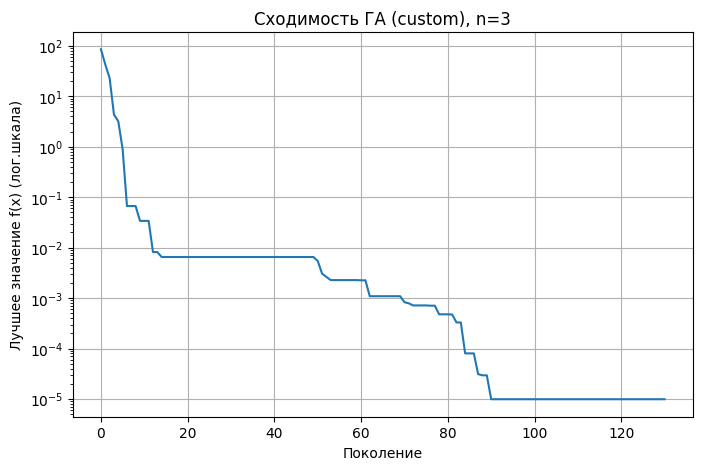


DEAP (toolbox), n=3
 best_x = [1.23877126e-26 6.15546113e-27 1.29399964e-27]
 best_f = 1.171290657019636e-51
 n_gen  = 250
 time_s = 0.9947871349999673

Сравнение best_f (custom vs DEAP): 9.917077788617155e-06 vs 1.171290657019636e-51


In [8]:
params_n3 = BASE.copy()
params_n3.update(dict(n_dim=3, pop_size=120, max_gens=250, patience=40, seed=SEED))

res3 = run_ga_custom(f1c, **params_n3)
print("ГА (custom), n=3")
print(" best_x =", res3["best_x"])
print(" best_f =", res3["best_f"])
print(" n_gen  =", res3["n_gen"])
print(" time_s =", res3["runtime_s"])

plt.figure()
plt.semilogy(np.maximum(np.array(res3["history_best"], dtype=float), 1e-16))
plt.xlabel("Поколение")
plt.ylabel("Лучшее значение f(x) (лог.шкала)")
plt.title("Сходимость ГА (custom), n=3")
plt.show()

# Для сравнения (toolbox) — DEAP
deap3 = run_deap_toolbox(
    n_dim=3,
    bounds=BASE["bounds"],
    pop_size=params_n3["pop_size"],
    pc=params_n3["pc"],
    pm=params_n3["pm"],
    max_gens=params_n3["max_gens"],
    seed=SEED
)

print("\nDEAP (toolbox), n=3")
print(" best_x =", deap3["best_x"])
print(" best_f =", deap3["best_f"])
print(" n_gen  =", deap3["n_gen"])
print(" time_s =", deap3["runtime_s"])

print("\nСравнение best_f (custom vs DEAP):", res3["best_f"], "vs", deap3["best_f"])


## 7) Контрольные вопросы

Ниже — компактные формулировки, которые можно использовать при устном объяснении.

1. **Что такое оптимальность?**  
   Оптимальность — свойство решения быть “наилучшим” по выбранному критерию (минимум/максимум целевой функции) среди допустимых решений.

2. **Что такое оптимизационная задача?**  
   Это задача выбора значений переменных $x$ из области допустимых решений так, чтобы экстремизировать целевую функцию:

$$
\min\limits_{x\in\Omega} f(x)\quad \text{или}\quad \max\limits_{x\in\Omega} f(x)
$$

3. **Что такое критерий оптимизации?**  
   Критерий оптимизации — правило сравнения решений, обычно выраженное целевой функцией или набором показателей (в многокритериальном случае).

4. **Что является целью оптимизационной задачи?**  
   Найти решение, обеспечивающее наилучшее значение критерия (например, минимальное значение стоимости, времени, ошибки и т.п.) при соблюдении ограничений.

5. **Что такое целевая функция в ГА?**  
   Это функция $f(x)$, измеряющая “качество” решения. В ГА именно она определяет, какие особи считаются более приспособленными.

6. **Каким образом строится целевая функция?**  
   По постановке задачи: берётся количественная мера качества (ошибка, стоимость, отклонение, штрафы за ограничения) и оформляется как вычислимая функция от переменных решения.

7. **Понятие экстремума и оптимума целевой функции.**  
   Экстремум — точка, где функция принимает локальный минимум/максимум.  
   Оптимум (глобальный экстремум) — наилучшее значение функции на всей области $\Omega$.

8. **Локальный и глобальный оптимум.**  
   Локальный оптимум — лучший только в некоторой окрестности точки, глобальный — лучший на всей области поиска.

9. **Как выбирается представление решения (кодирование) в ГА?**  
   Выбор зависит от типа переменных и природы задачи:  
   - двоичное кодирование — удобно для дискретных задач/демонстраций;  
   - вещественное — для непрерывной оптимизации;  
   - перестановочное — для комбинаторики (например, коммивояжёр).  
   Главное — чтобы операторы (кроссинговер/мутация) сохраняли допустимость решения или обеспечивали восстановление.

10. **Как определяется эффективность ГА?**  
   По качеству найденного решения (точность), устойчивости (разброс по запускам), времени работы и числу поколений/оценок функции.

11. **Основные цели и задачи ГА.**  
   Цель — поиск хороших (часто глобально близких к оптимуму) решений в сложных пространствах.  
   Задачи — глобальная оптимизация, настройка параметров, комбинаторная оптимизация, многокритериальная оптимизация.

12. **Отличительные особенности ГА.**  
   Популяционный поиск, стохастичность, использование операторов “наследования” (кроссинговер/мутация), работа только с оценкой целевой функции (без градиентов).

13. **Как создаётся начальная популяция?**  
   Обычно случайно (равномерно по области), иногда — “усиленная инициализация” (часть особей генерируется эвристически или выбираются лучшие из большего набора).

14. **Основные понятия ГА.**  
   Особь/хромосома, ген, популяция, фитнес, селекция, кроссинговер, мутация, поколение, элитизм, критерий останова.

15. **Опишите методику (процедуру) ГА.**  

    1.   сформировать начальную популяцию;
    2.   вычислить фитнес;
    3.   отобрать родителей;
    4.   сгенерировать потомков кроссинговером;
    5.   выполнить мутацию;  
    6.   сформировать новую популяцию (редукция/элитизм);
    7.   проверить критерий останова; повторять до выполнения.
